In [8]:
import torch
import h5py
from torch.utils.data import random_split, Dataset, DataLoader
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from scipy.special import beta
from torch.special import psi
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Subset
import wandb
import itertools
import os
import yaml
import time
import gc
import datetime
import optuna
import zarr
import seaborn as sns
from scipy import stats

if wandb.run is not None:
    wandb.run.tags = list(wandb.run.tags) + ["junk"]
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


innovation_nll_train_loss,██████▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▃▃▃▃▃▁▁▁▁▁▁▁▁▃▅▅
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse_train_loss,█▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mse_y,█▃▁▁▄
val/sim_error,▂█▅▁▁
val/snr_y_over_eps,▁▄▇█▅
val/std_max,█▄▃▂▁
val/std_mean,█▂▁▁▂
val/std_min,█▁▁▁▂
val/std_std,▄█▅▃▁
innovation_nll_train_loss,-0.97968


In [9]:
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/wideband_twocarrier_3.1V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/wideband_single_carrier_3.5V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/wideband_2.83V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/time_channel_2.83V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/unnormalized_channel_2.83V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/unnormalized_channel_3.5V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/normalized_channel_2.83V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/single_X_3.5V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/unnormalized_wide_channel_3.5V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/unnormalized_wide_channel_3.5V_scale2.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/unnormalized_wide_channel_test_3.5V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/unnormalized_wide_channel_3.13V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_25MHz_3.5V_scale2.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_15MHz_3.5V_scale2.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_15MHz_3.5V_scale4.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_7.5MHz_3.5V_scale8.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_4MHz_3.5V_scale2.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_3e5-4MHz_3.5V_scale4.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/channel_3e5-4MHz_3.5V_scale2.zarr"
file_path = "C:/Users/maild/mldrivenpeled/data/channel_measurements/zarr_files/test/channel_3e5-15MHz_3.5V_scale2.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/channel_3e5-15MHz_3.5V_scale2.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/channel_3e5-30MHz_3.5V_scale2.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_7.5MHz_3.5V_scale4.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_1e4-15MHz_3.5V_scale4.zarr"
# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps") # for M chip Macs
else:
    device = torch.device("cpu")
device = torch.device("cpu")
print(device)


WIDE_BAND = False
TIME_MODEL = True

cache_path = file_path.replace(".zarr", "_cached.pt").replace(".h5", "_cached.pt")

if os.path.exists(cache_path):
    data = torch.load(cache_path, map_location=device)
    sent_frames_time = data["sent_frames_time"].to(device)
    received_frames_time = data["received_frames_time"].to(device)
    FREQUENCIES = data["frequencies"].to(device)
    NUM_POINTS_SYMBOL = data["NUM_POINTS_SYMBOL"]
    CP_LENGTH = data["CP_LENGTH"]
    delta_f = FREQUENCIES[1] - FREQUENCIES[0]
    KS = (FREQUENCIES / delta_f).to(torch.int)
    K_MIN = int(KS[0].item())
    K_MAX = int(KS[-1].item())
    NUM_ZEROS = K_MIN - 1
    CP_RATIO = 0.25
    NUM_POINTS_FRAME = NUM_POINTS_SYMBOL - CP_LENGTH
    NUM_POS_FREQS_LOW_BAND = K_MAX + 1
    print(NUM_POINTS_FRAME  - 2 * NUM_POS_FREQS_LOW_BAND)
    UPSAMPLING_ZEROS = (NUM_POINTS_FRAME  - 2 * NUM_POS_FREQS_LOW_BAND) // 2

    print("Loaded from cache!")
else:
    print("No cache found — loading original dataset...")

    H5 = False
    FREQUENCIES = None
    if H5:
        # Extract all frame data
        DTYPE = torch.complex64
        sent = []
        received = []
        received_time = []
        FREQUENCIES = None
        with h5py.File(file_path, "r") as f:
            # Get frequency
            first_frame = list(f.keys())[-1]
            FREQUENCIES = torch.tensor(f[first_frame]['freqs'][:], dtype=DTYPE).to(device).real
            NUM_POINTS_SYMBOL = int(f[first_frame]['num_points_symbol'][()])
            CP_LENGTH = int(f[first_frame]['cp_length'][()])
            for frame in f:
                group = f[frame]
                sent.append(torch.tensor(group['sent'][:], dtype=DTYPE))
                received.append(torch.tensor(group['received'][:], dtype=DTYPE))
                received_time.append(torch.tensor(group['received_time'][:], dtype=DTYPE))
    else:
        # Open the Zarr root
        root = zarr.open(file_path, mode="r")

        # Get first frame

        # Load metadata (attributes live under .attrs)
        sent, received, received_time = [], [], []

        # Loop through frames
        num_skipped = 0
        for frame_key in root.group_keys():
            try:
                frame = root[frame_key]
                if FREQUENCIES is None:
                    FREQUENCIES = torch.tensor(frame["freqs"][:], dtype=torch.int).real
                    NUM_POINTS_SYMBOL = int(frame.attrs["num_points_symbol"])
                    CP_LENGTH = int(frame.attrs["cp_length"])
                else:
                    pass

                sent.append(torch.tensor(frame["sent"][:], dtype=torch.complex64))
                received.append(torch.tensor(frame["received"][:], dtype=torch.complex64))
                if "received_time" in frame:
                    received_time.append(torch.tensor(frame["received_time"][:], dtype=torch.float32))
            except:
                num_skipped += 1
                pass # skip corrupted frames
    print(f"Skipped {num_skipped} corrupted frames")

    sent_frames = torch.stack(sent).squeeze(1)
    sent_frames_active = sent_frames
    received_frames = torch.stack(received).squeeze(1)


    delta_f = FREQUENCIES[1] - FREQUENCIES[0]
    KS = (FREQUENCIES / delta_f).to(torch.int)
    K_MIN = int(KS[0].item())
    K_MAX = int(KS[-1].item())
    NUM_ZEROS = K_MIN - 1
    CP_RATIO = 0.25
    NUM_POINTS_FRAME = NUM_POINTS_SYMBOL - CP_LENGTH
    NUM_POS_FREQS_LOW_BAND = K_MAX + 1
    UPSAMPLING_ZEROS = (NUM_POINTS_FRAME  - 2 * NUM_POS_FREQS_LOW_BAND) // 2


    def symbols_to_time(X, num_padding_zeros: int, num_leading_zeros=0):
        # Make hermetian symmetric
        Nt, Nf = X.shape
        padding_zeros = torch.zeros(Nt, num_padding_zeros, device=device)
        leading_zeros = torch.zeros(Nt, num_leading_zeros, device=device)
        X = torch.cat([leading_zeros, X.to(device), padding_zeros], dim=-1)
        DC_Nyquist = torch.zeros((X.shape[0], 1), device=X.device)
        X_hermitian = torch.flip(X, dims=[1]).conj()
        X_full = torch.hstack([DC_Nyquist, X, DC_Nyquist, X_hermitian])

        # Convert to time domain
        x_time = torch.fft.ifft(X_full, dim=-1, norm="ortho").real
        return x_time.to(device)

    if len(received_time) > 0:
        N_shortest = min(t.size(-1) for t in received_time)
        N_longest = max(t.size(-1) for t in received_time)
        good_indices = [i for i, x in enumerate(received_time) if x.size(-1) == N_shortest]
        received_frames_time = torch.stack([t for t in received_time if t.size(-1) == N_shortest], dim=0).real.squeeze(1)
        sent_frames = sent_frames[good_indices]


    sent_frames_time = symbols_to_time(sent_frames, UPSAMPLING_ZEROS, NUM_ZEROS)
    # Add cyclic prefix
    sent_frames_time = torch.hstack((sent_frames_time[:, -CP_LENGTH:], sent_frames_time))
    received_frames_time = received_frames_time - received_frames_time.mean(dim=1, keepdim=True)



    # enforce OSA causality
    # sent_frames_time = sent_frames_time[:, :-1]
    # received_frames_time_resampled = received_frames_time_resampled[:,  1:]
    sent_frames_time = sent_frames_time.to(device)
    received_frames_time = received_frames_time.to(device)

    # TRUNCATE_SIZE = slice(CP_LENGTH, CP_LENGTH + 100)
    # sent_frames_time = sent_frames_time[:, TRUNCATE_SIZE]
    # received_frames_time = received_frames_time[:, TRUNCATE_SIZE]

    # Create a cache path
    cache_path = file_path.replace(".zarr", "_cached.pt").replace(".h5", "_cached.pt")

    torch.save({
        "sent_frames_time": sent_frames_time.cpu(),
        "received_frames_time": received_frames_time.cpu(),
        "frequencies": FREQUENCIES.cpu(),
        "NUM_POINTS_SYMBOL": NUM_POINTS_SYMBOL,
        "CP_LENGTH": CP_LENGTH
    }, cache_path)

class ChannelData(Dataset):
        def __init__(self,
                    sent_frames,
                    received_frames,
                    frequencies,
                    transform=None,
                    target_transform=None):

            self.sent_frames = sent_frames
            self.received_frames = received_frames
            assert len(sent_frames) == len(received_frames)

        def __len__(self):
            return len(self.sent_frames)

        def __getitem__(self, idx):
            return self.sent_frames[idx], self.received_frames[idx]

if TIME_MODEL:
    dataset = ChannelData(sent_frames_time, received_frames_time, FREQUENCIES)
else:
    dataset = ChannelData(sent_frames, received_frames, FREQUENCIES)

# Split sizes
train_size = int(0.9 * len(dataset))

val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size  # ensures total = 100%

# Perform split
train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator()
)
print("Train Size", train_size)

cpu
3000
Loaded from cache!
Train Size 1801


C:\Users\maild\AppData\Local\Temp\ipykernel_22916\3690177914.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(cache_path, map_location=device)


(100,) (100,)


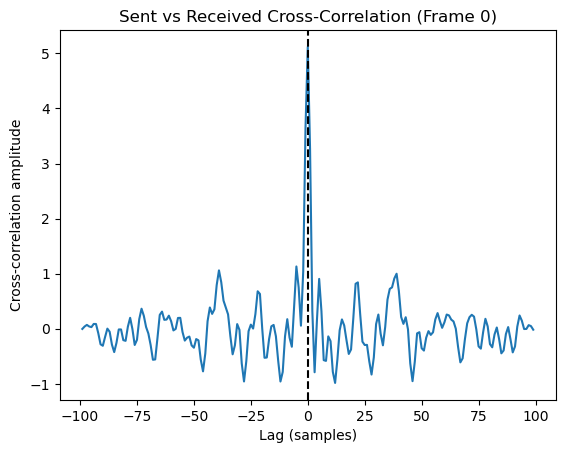

Peak lag: 0


In [10]:
s = sent_frames_time[100].cpu().numpy()
r = received_frames_time[100].cpu().numpy()

print(s.shape, r.shape)
corr = np.correlate(s, r, mode='full')
T = len(s)
zero_lag_index = T - 1

lags = np.arange(-T + 1, T)  # lag axis
plt.plot(lags, corr)
plt.axvline(0, color='k', linestyle='--')
plt.xlabel('Lag (samples)')
plt.ylabel('Cross-correlation amplitude')
plt.title('Sent vs Received Cross-Correlation (Frame 0)')
plt.show()

# Find best alignment
best_lag = lags[np.argmax(corr)]
print("Peak lag:", best_lag)

window = 4
lags = np.arange(-window, window + 1)
plt.plot(lags, corr[zero_lag_index - window:zero_lag_index + window + 1])

In [ ]:
def zero_last_layer(m):
    if isinstance(m, nn.Linear):
        nn.init.zeros_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class StateSpaceModel(nn.Module):
    def __init__(self,
                 deterministic_num_taps,
                 deterministic_state_size,
                 deterministic_hidden_size,
                 stochastic_state_size,
                 stochastic_hidden_size
                 ):
        super().__init__()
        self.deterministic_state_size = deterministic_state_size
        self.stochastic_state_size = stochastic_state_size
        self.deterministic_num_taps = deterministic_num_taps
        self.deterministic_state_map = nn.Sequential(
            nn.Linear(deterministic_num_taps + deterministic_state_size, deterministic_hidden_size),
            nn.SiLU(),
            nn.Linear(deterministic_hidden_size, deterministic_hidden_size),
            nn.SiLU(),
            nn.Linear(deterministic_hidden_size, deterministic_state_size)
        )
        self.deterministic_out_map = nn.Sequential(
            nn.Linear(deterministic_num_taps + deterministic_state_size, deterministic_hidden_size),
            nn.SiLU(),
            nn.Linear(deterministic_hidden_size, 1) # Predict next scalar ouptut
        )
        self.stochastic_state_map = nn.Sequential(
            nn.Linear(stochastic_state_size + deterministic_num_taps + 1, stochastic_hidden_size),
            nn.SiLU(),
            nn.Linear(stochastic_hidden_size, stochastic_hidden_size),
            nn.SiLU(),
            nn.Linear(stochastic_hidden_size, stochastic_state_size)
        )
        self.stochastic_out_map = nn.Sequential(
            nn.Linear(deterministic_num_taps + stochastic_state_size + deterministic_state_size, stochastic_hidden_size),
            nn.SiLU(),
            nn.Linear(stochastic_hidden_size, 1)
        )
        self.linear_det_out_map = nn.Linear(deterministic_num_taps + deterministic_state_size, 1)
        self.linear_det_state_map = nn.Linear(deterministic_num_taps + deterministic_state_size, deterministic_state_size)
        self.linear_stoch_state_map = nn.Linear(stochastic_state_size + deterministic_num_taps + 1, stochastic_state_size)
        self.linear_stoch_out_map = nn.Linear(deterministic_num_taps + stochastic_state_size + deterministic_state_size, 1)

        self.n0 = nn.Parameter(torch.zeros(deterministic_state_size))
        self.z0 = nn.Parameter(torch.zeros(stochastic_state_size))

        # Make it so that the stochastic output starts at zero
        self.deterministic_state_map[-1].apply(zero_last_layer)
        self.deterministic_out_map[-1].apply(zero_last_layer)
        self.stochastic_state_map[-1].apply(zero_last_layer)
        self.stochastic_out_map[-1].apply(zero_last_layer)
        self.mode = "nonlinear"

    def forward(self, x, y):
        mode = self.mode
        device = x.device
        y_pred = torch.zeros_like(x, device=device)
        e_pred = torch.zeros_like(x, device=device)
        T = x.size(-1)
        B = x.size(0)
        # n_t = torch.zeros(B, self.deterministic_state_size, device=device)
        # z_t = torch.zeros(B, self.stochastic_state_size, device=device)
        n_t = self.n0.unsqueeze(0).expand(B, -1)  # [B, nx]
        z_t = self.z0.unsqueeze(0).expand(B, -1)  # [B, nz]
        # add zeros in front equal to num_taps - 1
        x = torch.cat([torch.zeros(B, self.deterministic_num_taps - 1, device=device), x], dim=-1)
        for t in range(T):
            x_t = x[:, t: t + self.deterministic_num_taps]

            if mode == "linear":
                y_t_pred = self.linear_det_out_map(torch.cat([x_t, n_t], dim=-1))
            else:
                y_t_pred = self.deterministic_out_map(torch.cat([x_t, n_t], dim=-1)) + self.linear_det_out_map(torch.cat([x_t, n_t], dim=-1))

            if y is None:
                '''INFERENCE MODE'''
                y_pred[:, t] = y_t_pred.squeeze(-1)
                # Assume residuals are an innovation process with zero mean
                if mode == "linear":
                    n_t = n_t + self.linear_det_state_map(torch.cat([x_t, n_t], dim=-1)) # [B, nx + num_taps]
                else:
                    n_t = n_t + self.deterministic_state_map(torch.cat([x_t, n_t], dim=-1)) + self.linear_det_state_map(torch.cat([x_t, n_t], dim=-1)) # [B, nx + num_taps]

            else:
                '''TRAINING MODE'''
                # Training mode
                y_t = y[:, t]
                r_t = y_t.unsqueeze(-1) - y_t_pred

                if mode == "linear":
                    nonlinear_noise_t = self.linear_stoch_out_map(torch.cat([x_t, n_t, z_t], dim=-1))
                else:
                    nonlinear_noise_t = self.stochastic_out_map(torch.cat([x_t, n_t, z_t], dim=-1)) + self.linear_stoch_out_map(torch.cat([x_t, n_t, z_t], dim=-1))
                y_t_next_pred = y_t_pred + nonlinear_noise_t
                y_pred[:, t] = y_t_next_pred.squeeze(-1)
                e_t = r_t - nonlinear_noise_t
                e_pred[:, t] = e_t.squeeze(-1)
                # Make state updates

                if mode == "linear":
                    z_t = z_t + self.linear_stoch_state_map(torch.cat([x_t, z_t, r_t], dim=-1))
                    n_t = n_t + self.linear_det_state_map(torch.cat([x_t, n_t], dim=-1)) # [B, nx + num_taps]
                else:
                    z_t = z_t + self.stochastic_state_map(torch.cat([x_t, z_t, r_t], dim=-1)) + self.linear_stoch_state_map(torch.cat([x_t, z_t, r_t], dim=-1))
                    n_t = n_t + self.deterministic_state_map(torch.cat([x_t, n_t], dim=-1)) + self.linear_det_state_map(torch.cat([x_t, n_t], dim=-1)) # [B, nx + num_taps]
        return y_pred, e_pred

class ProbabilisticStateSpaceModel(nn.Module):
    def __init__(self,
                 num_taps,
                 state_size,
                 hidden_size,
                 ar_taps,
                 detach_residuals=True,
                 linear_fast=True
                 ):
        super().__init__()
        self.state_size = state_size
        self.num_taps = num_taps
        self.linear_fast = linear_fast
        self.detach_residuals = detach_residuals
        self.state_map = nn.Sequential(
            nn.Linear(num_taps + state_size, hidden_size),
            # nn.SiLU(),
            # nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, state_size)
        )
        self.state_out_map = nn.Sequential(
            nn.Linear(num_taps + state_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, 2 + ar_taps) # Predict mean and std
        )
        if linear_fast:
            self.fast_feedthrough = nn.Linear(num_taps, 1, bias=False)
        else:
            self.fast_feedthrough = nn.Sequential(
                nn.Linear(num_taps, hidden_size, bias=False),
                nn.SiLU(),
                nn.Linear(hidden_size, 1, bias=False)
            )
        # nn.init.zeros_(self.fast_feedthrough.weight)
        # nn.init.zeros_(self.fast_feedthrough.weight)
        self.n0 = nn.Parameter(torch.zeros(state_size))
        # self.alpha = nn.Parameter(torch.tensor(0.5))
        self.alpha = nn.Parameter(torch.tensor(3 * torch.randn(state_size)))
        # self.state_map[-1].apply(zero_last_layer)
        # self.state_out_map[-1].apply(zero_last_layer)
        self.ar_coeffs = nn.Parameter(torch.zeros(ar_taps))
        self.ar_taps = ar_taps

    def _whiten(self, x, ar_preds):
        out = torch.zeros_like(x)
        for t in range(x.size(-1)):
            x_whitened_t = x[:, t]
            for i in range(self.ar_taps):
                j = t - (i + 1)
                if j >= 0: # Enforce boundary
                #   x_whitened_t = x_whitened_t - nn.Tanh(ar_preds[i]) * x[:, j]
                    if self.detach_residuals:
                        x_whitened_t = x_whitened_t - ar_preds[:, t, i] * x[:, j].detach()
                    else:
                        x_whitened_t = x_whitened_t - ar_preds[:, t, i] * x[:, j] # Remove the possibility of cheating by spiking previous errors
            out[:, t] = x_whitened_t
        return out

    def _step(self, xt, nt):
        inp = torch.cat([xt, nt], dim=-1)
        out = self.state_out_map(inp)
        y_pred = out[:, 0]
        y_fast = self.fast_feedthrough(xt).squeeze(-1)
        # y_fast_sq = self.fast_square(xt ** 2).squeeze(-1)
        y_pred = y_pred + y_fast
        std_pred = F.softplus(out[:, 1]) + 1e-4
        ar_preds = F.tanh(out[:, 2:])
        delta_n = self.state_map(inp)
        alpha = torch.sigmoid(self.alpha)
        nt_next = (1.0 - alpha) * nt + delta_n
        return y_pred, std_pred, ar_preds, nt_next

    def forward_train(self, x, y):
        device = x.device
        T = x.size(-1)
        B = x.size(0)
        y_pred = torch.zeros(B, T, device=device)
        std_pred = torch.zeros(B, T, device=device)
        residuals = torch.zeros(B, T, device=device)
        ar_preds = torch.zeros(B, T, self.ar_taps, device=device)
        innovations = torch.zeros(B, T, device=device)
        nt = self.n0.unsqueeze(0).repeat(B, 1).clone()  # [B, nx]
        # add zeros in front equal to num_taps - 1
        x = torch.cat([torch.zeros(B, self.num_taps - 1, device=device), x], dim=-1)

        for t in range(T):
            xt = x[:, t: t + self.num_taps]
            y_pred_t, std_pred_t, ar_preds_t, nt = self._step(xt, nt)
            y_pred[:, t] = y_pred_t

            # get residuals
            r_t = (y[:, t] - y_pred_t)
            residuals[:, t] = r_t #
            std_pred[:, t] = std_pred_t
            eps_t = r_t
            innovations[:, t] = eps_t
            ar_preds[:, t, :] = ar_preds_t

        # whiten the innovations
        innovations = self._whiten(innovations, ar_preds)
        return y_pred, std_pred, innovations


    def forward_simulate(self, x, eps=None):
        device = x.device
        T = x.size(-1)
        B = x.size(0)
        y_pred = torch.zeros(B, T, device=device)
        if eps is None:
            eps = torch.randn(B, T, device=device)
        residuals = torch.zeros_like(x, device=device)
        x = torch.cat([torch.zeros(B, self.num_taps - 1, device=device), x], dim=-1)
        n_t = self.n0.unsqueeze(0).expand(B, -1)
        for t in range(T):
            xt = x[:, t: t + self.num_taps]
            y_pred_t, std_pred_t, ar_preds, n_t = self._step(xt, n_t)
            ar_component = 0.0
            for i in range(self.ar_taps):
                lag = t - i - 1
                if lag < 0:
                    break
                ar_component += ar_preds[:, i] * residuals[:, lag]    

            r_t = ar_component + std_pred_t * eps[:, t]
            residuals[:, t] = r_t
            y_pred[:, t] = y_pred_t + r_t

        return y_pred





In [12]:
def visualize_std(model, input_tensor):
    model.eval()
    with torch.no_grad():
        noisy_sample, mean_pred, std_pred, _ = model(input_tensor)

    xin = input_tensor[0].cpu().numpy()
    mean = mean_pred[0].cpu().numpy()
    std = std_pred[0].cpu().numpy()
    sample = noisy_sample[0].cpu().numpy()

    time_steps = np.arange(len(xin))

    plt.figure(figsize=(14, 7))

    plt.plot(time_steps, mean, label='Predicted Mean', color='blue', linewidth=2)

    plt.fill_between(
        time_steps,
        mean - 2 * std,
        mean + 2 * std,
        color='blue',
        alpha=0.2,
        label='Uncertainty (±2σ)'
    )

    plt.plot(time_steps, sample, label='Generated Sample', color='green', alpha=0.7)

    plt.title('Model Prediction with Learned Uncertainty')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.show()

In [13]:
# def regularizer(model, rho_theta, tau, rho_w):
#     # θ = all parameters of both models
#     l2_theta = 0.0
#     l1_theta = 0.0
#     for p in list(model.parameters()):
#         l2_theta = l2_theta + torch.sum(p ** 2)
#         l1_theta = l1_theta + torch.sum(p.abs())

#     # \hat w_0 = [n0, z0] from the state-space model
#     w0_vec = torch.cat([model.n0.view(-1), model.z0.view(-1)])
#     l2_w0 = torch.sum(w0_vec ** 2)

#     reg = 0.5 * float(rho_theta) * l2_theta + float(tau) * l1_theta + 0.5 * float(rho_w) * l2_w0
#     return reg

def correlation(x: torch.Tensor, y: torch.Tensor, lag_max: int) -> torch.Tensor:
    '''
    Computes batched and normalized correlation between x and y [B, N] up to lag_max times
    '''
    x_centered = x - x.mean(dim=-1, keepdims=True)
    y_centered = y - y.mean(dim=-1, keepdims=True)
    cross_corrs = []
    N = x_centered.shape[1]
    assert lag_max <= N, "Lag max too long"
    x_rms = torch.sqrt((1 / N) * torch.sum(x_centered ** 2, dim=-1, keepdims=True))
    y_rms = torch.sqrt((1 / N) * torch.sum(y_centered ** 2, dim=-1, keepdims=True))
    for lag in range(-lag_max, lag_max+1):
        if lag >= 0:
            shifted_x = x_centered[:, lag:]
            shifted_y = y_centered[:, :N-lag]
        else:
            shifted_x = x_centered[:, :N+lag]
            shifted_y = y_centered[:, -lag:]

        corr = torch.mean(shifted_x * shifted_y, dim=-1, keepdim=True)
        corr_norm = torch.mean(corr / (x_rms * y_rms), dim=0) # Average across batches
        cross_corrs.append(corr_norm)

    return torch.stack(cross_corrs, dim=0)


def compute_billings_corrs(batched_residuals: torch.Tensor, batched_inputs: torch.Tensor,
                           lag_max: int, log_wandb: bool = False, prefix: str = "billings_correlation"):
    '''
    Computs the Billing's et al correlation parameters to determine whether a model
    has captured the system's nonlinearity

    Args:
        batched_residuals: model errors of shape [B, N]
        batched_inputs: model inputs of shape [B, N]
    '''


    batched_residuals = batched_residuals - batched_residuals.mean(dim=-1, keepdim=True)
    batched_inputs = batched_inputs - batched_inputs.mean(dim=-1, keepdim=True)

    def _plot_and_log(y_np, title, key):
        fig, ax = plt.subplots(figsize=(6, 3.5))
        ax.plot(lags, y_np.ravel(), label=key)
        ax.hlines(confidence_value, -lag_max, lag_max, colors='r', linestyles='dashed', label="95% CI")
        ax.hlines(-confidence_value, -lag_max, lag_max, colors='r', linestyles='dashed')
        ax.set_title(title)
        ax.set_xlabel("Lag")
        ax.set_ylabel("Correlation")
        ax.legend()
        plt.tight_layout()

        if log_wandb:
            wandb.log({f"{prefix}/{key}": wandb.Image(fig)})
        else:
            plt.show()
        plt.close(fig)

    confidence_value = 1.96 / np.sqrt(batched_residuals.shape[1])
    lags = lags = np.arange(-lag_max, lag_max + 1)

    phi_r_r = correlation(batched_residuals, batched_residuals, lag_max).cpu().numpy()
    _plot_and_log(phi_r_r, "Residual Autocorrelation", "residual_autocorr")
    phi_u_r = correlation(batched_inputs, batched_residuals, lag_max).cpu().numpy()
    _plot_and_log(phi_u_r, "Input-Residual Correlation", "input_residual_corr")
    # shifted_product = batched_residuals[:, 1:] * batched_inputs[:, 1:]
    phi_r_ru = correlation(batched_residuals, batched_inputs * batched_residuals, lag_max).cpu().numpy()
    _plot_and_log(phi_r_ru, "Residual-Residual*Input Correlation", "residual_residual_input_corr")

    u_prime_squared = torch.square(batched_inputs) - torch.mean(batched_inputs ** 2, dim=-1, keepdim=True)
    phi_u_prime_squared_r = correlation(u_prime_squared, batched_residuals, lag_max).cpu().numpy()
    _plot_and_log(phi_u_prime_squared_r, "(U^2)' Residual Correlation", "u_squared_prime_residual_corr")

    phi_u_prime_squared_r_squared = correlation(u_prime_squared, batched_residuals ** 2, lag_max).cpu().numpy()
    _plot_and_log(phi_u_prime_squared_r_squared, "(U^2)' Residual ^2 Correlation", "u_squared_prime_residual_squared_corr")


sns.reset_defaults()      # resets seaborn styles


def log_mean_std_plot(y, y_pred, std_pred, tag="val/mean_std"):
    """
    y, y_pred, std_pred: tensors [B, T]
    Logs a wandb image showing predicted mean ±2σ for a 100-sample snippet.
    """

    # Pick first sample in batch and first 100 steps
    y_np = y[0, :100].detach().cpu().numpy()
    mean_np = y_pred[0, :100].detach().cpu().numpy()
    std_np = std_pred[0, :100].detach().cpu().numpy()

    t = np.arange(100)

    fig, ax = plt.subplots(figsize=(12, 5))

    ax.plot(t, mean_np, label="Predicted Mean", color="blue", linewidth=2)
    ax.fill_between(t, mean_np - 2*std_np, mean_np + 2*std_np,
                    color="blue", alpha=0.20, label="±2σ")

    ax.plot(t, y_np, label="Ground Truth", color="black", alpha=0.8)

    ax.set_title("Predicted Mean ± 2σ (first 100 samples)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.grid(True, linestyle=":")
    ax.legend()

    wandb.log({tag: wandb.Image(fig)})

    plt.close(fig)


def log_phi_heatmap(phis, tag="val/phi_heatmap", max_T=100):
    """
    phis: tensor [B, T, ar_taps]
    Logs a heatmap of the AR kernels over time.
    """

    # Use first sample in batch
    phi_np = phis[0].detach().cpu().numpy()

    T = phi_np.shape[0]
    p = phi_np.shape[1]

    # Optionally crop long sequences
    if T > max_T:
        phi_np = phi_np[:max_T]
        T = max_T

    fig, ax = plt.subplots(figsize=(12, 4))
    im = ax.imshow(phi_np.T, aspect='auto', origin='lower', cmap='viridis')

    ax.set_title("AR Coefficients φᵢ[t] Over Time")
    ax.set_xlabel("Time t")
    ax.set_ylabel("AR tap index i")

    fig.colorbar(im, ax=ax)
    wandb.log({tag: wandb.Image(fig)})

    plt.close(fig)


def gaussian_nll(difference, y_pred_std):
    term1 = 0.5 * torch.log(2 * torch.pi * (y_pred_std ** 2))
    term2 = 0.5 * torch.square((difference) / y_pred_std)
    loss = torch.mean(term1 + term2)
    if torch.isnan(loss):
        raise ValueError("NaN in loss")
    return loss


def train(model, optimizer, loop, config):
    model.train()
    total_loss = 0
    batch_count = 0
    for batch in loop:
        x, y = batch[0], batch[1]
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred, std_pred, e_pred = model.forward_train(x, y)
        # loss = torch.mean((e_pred ** 2)) #+ regularizer(model, config.rho_theta, config.tau, config.rho_w)
        loss = gaussian_nll(e_pred, std_pred)
        mse_loss = F.mse_loss(y, y_pred)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        wandb.log({"innovation_nll_train_loss": loss.item()})
        wandb.log({"mse_train_loss": mse_loss.item()})
        lr = optimizer.param_groups[0]["lr"]
        wandb.log({"learning_rate": lr})
        batch_count += 1
        loop.set_postfix(loss=loss.item())
        if batch_count % 10 == 0:
            with torch.no_grad():
                compute_billings_corrs(e_pred, x, 20, log_wandb=True, prefix="train_billings_correlation")
                # log_phi_heatmap(phis, tag="val/phi_heatmap")

    loop.close()
    return model

def val(model, val_loader, config, step):
    model.eval()

    with torch.no_grad():
        stds = []
        mse_list = []
        snr_list = []
        sim_list = []
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            y_pred, std_pred, e_pred = model.forward_train(x, y)

            
            # Simulation validation
            y_pred_sim = model.forward_simulate(x)

            sim_list.append(F.mse_loss(y_pred_sim, y, reduction="mean").item())

            stds.append(std_pred)
            mse_list.append(F.mse_loss(y_pred, y, reduction="mean").item())

            # simple SNR estimate: var(y)/var(innovation)
            num = y.var(dim=-1).mean().item()
            den = e_pred.var(dim=-1).mean().item()
            snr_list.append(num / (den + 1e-8))



        log_mean_std_plot(
            y, y_pred, std_pred,
            tag="val/mean_std_plot"
        )

        stds_all = torch.cat(stds, dim=0)  # [N, T]
        wandb.log({
            "val/std_mean": stds_all.mean().item(),
            "val/std_std": stds_all.std().item(),
            "val/std_min": stds_all.min().item(),
            "val/std_max": stds_all.max().item(),
            "val/mse_y": np.mean(mse_list),
            "val/snr_y_over_eps": np.mean(snr_list),
            "val/sim_error": np.mean(sim_list)
        })



    return np.mean(mse_list)


In [14]:
def make_optimizer(mode, channel_model, noise_model, channel_model_linear, config):
    if mode == "linear_only":
        return optim.AdamW(
            list(channel_model_linear),
            lr=float(config.lr_linear),
            weight_decay=float(config.wd_linear)
        )
    if mode == "channel_only":
        return optim.AdamW(
            list(channel_model),
            lr=float(config.lr_channel),
            weight_decay=float(config.wd_channel)
        )

    elif mode == "noise_only":
        return optim.AdamW(
            list(noise_model),
            lr=float(config.lr_noise),
            weight_decay=float(config.wd_noise)
        )

    elif mode == "joint":
        return optim.AdamW(
            list(channel_model) +
            list(noise_model),
            lr=float(config.lr_joint),
            weight_decay=float(config.wd_joint)
        )

    else:
        raise ValueError("Unknown mode")



def run_experiment(config):

    grid_id = config.get('grid_run_id', 'manual_run')
    # Start Weights and Biases session
    wandb.init(project="mldrivenpeled",
            config=config, tags=['channel_model', grid_id], group=grid_id)
    config = wandb.config

    print(f"WandB run info:")
    print(f"  Name: {wandb.run.name}")
    print(f"  ID: {wandb.run.id}")
    print(f"  URL: {wandb.run.url}")
    print("Chosen hyperparameters for this session:")
    print(config)

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=config.batch_size, drop_last=False)
    test_loader = DataLoader(test_dataset)
    val_loader = DataLoader(val_dataset, shuffle=True, batch_size=config.batch_size, drop_last=False)

    # channel_model = StateSpaceModel(
    #     deterministic_num_taps=config.deterministic_num_taps,
    #     deterministic_hidden_size=config.deterministic_hidden_size,
    #     stochastic_hidden_size=config.stochastic_hidden_size,
    #     stochastic_state_size=config.stochastic_state_size,
    #     deterministic_state_size=config.deterministic_state_size
    # ).to(device)



    # def init_xavier_zero_bias(m):
    #     if isinstance(m, nn.Linear):
    #         nn.init.xavier_uniform_(m.weight)
    #         nn.init.zeros_(m.bias)

    # channel_model.apply(init_xavier_zero_bias)

    channel_model = ProbabilisticStateSpaceModel(
        num_taps=config.num_taps,
        hidden_size=config.hidden_size,
        state_size=config.state_size,
        ar_taps=config.ar_taps,
        linear_fast=config.linear_fast,
        detach_residuals=config.detach_residuals
    ).to(device)

    # channel_model_params = (
    #     list(channel_model.deterministic_out_map.parameters()) +
    #     list(channel_model.deterministic_state_map.parameters()) +
    #     [channel_model.n0]
    # )

    # channel_model_linear_params = (
    #     list(channel_model.linear_det_out_map.parameters()) +
    #     list(channel_model.linear_det_state_map.parameters()) +
    #     list(channel_model.linear_stoch_state_map.parameters()) +
    #     list(channel_model.linear_stoch_out_map.parameters())
    # )

    # noise_model_params = (
    #     list(channel_model.stochastic_out_map.parameters()) +
    #     list(channel_model.stochastic_state_map.parameters()) +
    #     [channel_model.z0]
    # )



    # lbfgs = torch.optim.LBFGS(
    #         channel_model.parameters(),
    #         lr=1.0,
    #         max_iter=20,
    #         history_size=10,
    #         line_search_fn="strong_wolfe"
    #     )

    # num_adam_epochs = config.num_adam_epochs
    # num_LBFGS_epochs = config.num_LBFGS_epochs
    # for epoch in range(num_adam_epochs):
    #     loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_adam_epochs}', leave=False)
    #     train(channel_model, adam, loop, config)
    #     avg_val_loss = val(channel_model, val_loader, config)
    #     scheduler.step(avg_val_loss)


    schedule = config.training_schedule
    epoch_counter = 0
    for phase in schedule:
        mode = phase["mode"]
        num_phase_epochs = phase["epochs"]

        # optimizer = make_optimizer(mode, channel_model_params, noise_model_params, channel_model_linear_params, config)
        optimizer = optim.AdamW(
            channel_model.parameters(),
            lr=float(config.lr),
            weight_decay=float(config.wd))

        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, min_lr=1e-6)
        channel_model.mode = mode
        for local_epoch in range(num_phase_epochs):
            epoch_counter += 1
            loop = tqdm(train_loader, desc=f'Epoch {epoch_counter} [{mode}]')
            train(channel_model, optimizer, loop, config)
            avg_val_loss = val(channel_model, val_loader, config, local_epoch)
            scheduler.step(avg_val_loss)

    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Trainable parameters: {count_parameters(channel_model):,}")
    # Freeze modelj
    for param in channel_model.parameters():
        param.requires_grad = False

    # Save model
    torch.save({
        "channel_model": channel_model.state_dict(),
    }, "channel_model_final.pth")

    artifact = wandb.Artifact("channel_model", type="model")
    artifact.add_file("channel_model_final.pth")
    wandb.log_artifact(artifact)
    print("Finished!")
    run_name = wandb.run.name
    return avg_val_loss, run_name, channel_model, train_loader, val_loader

# param_grid = {
#     'lr': [1e-3],
#     'deterministic_hidden_size': [16],
#     'stochastic_hidden_size': [16],
#     'deterministic_num_taps': [4],
#     'stochastic_state_size': [2],
#     'deterministic_state_size': [2]
# }

# param_grid = {
#     'lr': [1e-3],
#     'hidden_size': [8, 16, 32],
#     'num_taps': [4, 8, 10, 12],
#     'state_size': [2, 4, 6],
#     'wd': [1e-2, 1e-3, 1e-4]
# }

grid_run_id = datetime.datetime.now().strftime("grid_%Y%m%d_%H%M%S")
print(f"Starting Grid Search ID: {grid_run_id}")
# param_grid = {
#     'lr': [1e-3],
#     'hidden_size': [16, 32],
#     'num_taps': [10],
#     'state_size': [3, 4, 8, 16],
#     'wd': [1e-3],
#     'ar_taps':[4, 6, 8]
# }

param_grid = {
    'lr': [1e-3],
    'hidden_size': [8, 16, 32],
    'num_taps': [10],
    'state_size': [2, 4, 8, 12],
    'wd': [1e-3],
    'ar_taps':[0, 4, 10],
    'detach_residuals': [True, False],
    'linear_fast': [True, False]
}
keys, values = zip(*param_grid.items())

best_val_loss = float('inf')
best_config = None
best_run_id = None
for v in itertools.product(*values):
    config = dict(zip(keys, v))

    # load static config defaults
    with open("../state_space_config.yml", "r") as f:
        base_cfg = yaml.safe_load(f)


    # override base config
    base_cfg.update(config)
    base_cfg['grid_run_id'] = grid_run_id

    val_loss, run_id, channel_model, train_loader, val_loader = run_experiment(base_cfg)

    innovations = []
    all_residuals = []
    all_inputs = []
    all_stds = []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            all_inputs.append(x)
            y = y.to(device)
            y_pred, std_pred, e_pred = channel_model.forward_train(x, y)
            innovations.append(e_pred)
            all_stds.append(std_pred)
    all_inputs_tensor = torch.cat(all_inputs, dim=0)[:100, :]
    all_innovations_tensor = torch.cat(innovations, dim=0)[:100, :]
    al_stds_innovations_tensor = torch.cat(innovations, dim=0)[:100, :]


    compute_billings_corrs(all_innovations_tensor, all_inputs_tensor, 20, log_wandb=True, prefix="val_billings_correlation")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_config = base_cfg
        best_run_id = run_id
        print("New best found!")
        print(f"Best Run ID: {best_run_id}")
        print(f"Best Validation Loss: {best_val_loss}")
        print(f"Best Configuration: {best_config}")
        print("New best found!")
    wandb.finish()


Starting Grid Search ID: grid_20251201_145150


WandB run info:
  Name: deft-serenity-7589
  ID: bs5eific
  URL: https://wandb.ai/dylanbackprops-university-of-washington/mldrivenpeled/runs/bs5eific
Chosen hyperparameters for this session:
{'batch_size': 32, 'num_taps': 10, 'hidden_size': 8, 'state_size': 2, 'ar_taps': 0, 'gain': 20, 'lr': 0.001, 'wd': 0.001, 'dilation_base': 2, 'scheduler_type': 'reduce_lr_on_plateu', 'weight_init': 'default', 'Nf': 1499, 'Nt': 1, 'flow': 300000, 'fhigh': '15e6', 'fnyquist': '30e6', 'subcarrier_spacing': '1e4', 'dc_offset': 3.5, 'training_schedule': [{'epochs': 10, 'mode': 'normal'}], 'detach_residuals': True, 'linear_fast': True, 'grid_run_id': 'grid_20251201_145150'}


AttributeError: 'ProbabilisticStateSpaceModel' object has no attribute 'fast_square'

In [ ]:
print(f"Best Run ID: {best_run_id}")
print(f"Best Validation Loss: {best_val_loss}")
print(f"Best Configuration: {best_config}")

Best Run ID: fancy-bush-7587
Best Validation Loss: 0.006329452818525689
Best Configuration: {'batch_size': 32, 'num_taps': 10, 'hidden_size': 32, 'state_size': 12, 'ar_taps': 10, 'gain': 20, 'lr': 0.001, 'wd': 0.001, 'dilation_base': 2, 'scheduler_type': 'reduce_lr_on_plateu', 'weight_init': 'default', 'Nf': 1499, 'Nt': 1, 'flow': 300000, 'fhigh': '15e6', 'fnyquist': '30e6', 'subcarrier_spacing': '1e4', 'dc_offset': 3.5, 'training_schedule': [{'epochs': 6, 'mode': 'normal'}], 'grid_run_id': 'grid_20251201_144031'}


In [ ]:
# # Load in chosen model

# api = wandb.Api()
# run = api.run("dylanbackprops-university-of-washington/mldrivenpeled/oibih492") # Variable
# model_name = "channel_model_final"
# artifact = api.artifact("dylanbackprops-university-of-washington/mldrivenpeled/channel_model:v581") # Variable
# artifact_dir = artifact.download()
# remote_config = run.config
# run_name = run.name
# print("Channel Run name:", run_name)

# channel_model = StateSpaceModel(
#     nlayers=remote_config['nlayers'],
#     dilation_base=remote_config['dilation_base'],
#     num_taps=remote_config['num_taps'],
#     hidden_channels=remote_config['hidden_channels'],
#     learn_noise=remote_config['learn_noise'],
#     gaussian=remote_config['gaussian']
# ).to(device)


# channel_model_path = os.path.join(artifact_dir, model_name + ".pth")
# checkpoint = torch.load(channel_model_path)
# channel_model.load_state_dict(checkpoint["channel_model"])

# # Freeze before moving to device
# for param in channel_model.parameters():
#     param.requires_grad = False

# channel_model = channel_model.to(device).float()
# channel_model.eval()

# print("Channel model parameters frozen:",
#       all(not param.requires_grad for param in channel_model.parameters()))

In [ ]:
best_run_id

In [ ]:

import matplotlib.cm as cm


t = torch.linspace(0, 1, NUM_POINTS_FRAME)


freqs = torch.arange(K_MIN, 3000)[::100]

# # Downsample frequency sweep
# freqs = KS[::200].cpu()


# print(freqs)
freq_step_hz = 10e3
freqs_hz = freqs * freq_step_hz


fig, ax = plt.subplots(figsize=(10, 10))

# Normalize by real frequency values
norm = plt.Normalize(vmin=min(freqs_hz), vmax=max(freqs_hz))
cmap = cm.get_cmap('viridis')



def loop_area(x, y):
    # x, y are 1D numpy arrays
    return 0.5 * np.trapezoid(y, x)

areas = []
for f_idx, f_hz in zip(freqs, freqs_hz):
    x = 3 * torch.sin(2 * np.pi * f_idx * t).unsqueeze(0).to(device)
    _, y, _, _ = channel_model(x)

    x = x.squeeze().cpu().numpy()
    y = y.squeeze().cpu().numpy()

    ax.scatter(x, y, color=cmap(norm(f_hz)), s=0.5, alpha=0.5)
    areas.append(loop_area(x,y))


sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Frequency (kHz)")
tick_vals = np.linspace(min(freqs_hz), max(freqs_hz), 6)
cbar.set_ticks(tick_vals)
cbar.set_ticklabels((tick_vals.numpy() / 1e3).astype(int))  # display in kHz

ax.set_title("Model Prediction for Sinusoidal Inputs at Various Frequencies")
ax.set_xlabel("Input")
ax.set_ylabel("Output")
ax.grid(True, linestyle=':')
plt.tight_layout()
plt.show()